In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [3]:
def display_important_features_rf_forest(classifier, features):
    importances = classifier.feature_importances_
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [4]:
#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [5]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data['train_rec'] = 0
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 10 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
train_rec       2117 non-null int64
dtypes: int64(5), object(5)
memory usage: 165.5+ KB


### Extract some historical data

In [8]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [9]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [10]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,0,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,0,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,0,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,0,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,0,1,2015


In [12]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010


In [13]:
tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,School,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22


In [14]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [15]:
tourney_data.drop(columns=['School_t','School_o','Games_t','Games_o','team_id_o'],inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team,team_id_t,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [16]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [17]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [18]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [19]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [20]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [21]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','team_t','team_id_t',
                                         'team_o','team_id_o','game_result','start_season','Game Result',
                                         'conf_name_t','conf_name_o','train_rec']).copy()
feature_data.head()

,season_t,seed_t,seed_o,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,8,9,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,7,10,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,12,5,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,12,5,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,1,11,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [43]:
feature_data_diff = feature_data.copy()
feature_data_diff['margin_victory_t'] = feature_data_diff['pts_avg_t'] - feature_data_diff['opp_pts_avg_t']
feature_data_diff['margin_victory_o'] = feature_data_diff['pts_avg_o'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['delta_margin_victory_avg'] = feature_data_diff['margin_victory_t'] - feature_data_diff['margin_victory_o']

feature_data_diff['delta_fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']

#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['delta_off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['delta_allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['delta_ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']

feature_data_diff['to_net_avg_t'] = feature_data_diff['to_avg_t'] - feature_data_diff['steal_avg_t']
feature_data_diff['to_net_avg_o'] = feature_data_diff['to_avg_o'] - feature_data_diff['steal_avg_o']
feature_data_diff['delta_to_net_avg'] = feature_data_diff['to_net_avg_t'] - feature_data_diff['to_net_avg_o']

feature_data_diff['delta_win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['delta_off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['delta_allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['delta_ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']

feature_data_diff['delta_allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['seed_t'] - feature_data_diff['seed_o']

feature_data_diff['delta_srs'] = feature_data_diff['SRS_t'] - feature_data_diff['SRS_o']
feature_data_diff['delta_sos'] = feature_data_diff['SOS_t'] - feature_data_diff['SOS_o']

feature_data_diff['delta_sag'] = feature_data_diff['SAG_t'] - feature_data_diff['SAG_o']
feature_data_diff['delta_wlk'] = feature_data_diff['WLK_t'] - feature_data_diff['WLK_o']
feature_data_diff['delta_wol'] = feature_data_diff['WOL_t'] - feature_data_diff['WOL_o']
feature_data_diff['delta_rth'] = feature_data_diff['RTH_t'] - feature_data_diff['RTH_o']
feature_data_diff['delta_col'] = feature_data_diff['COL_t'] - feature_data_diff['COL_o']
feature_data_diff['delta_pom'] = feature_data_diff['POM_t'] - feature_data_diff['POM_o']
feature_data_diff['delta_dol'] = feature_data_diff['DOL_t'] - feature_data_diff['DOL_o']
feature_data_diff['delta_rpi'] = feature_data_diff['RPI_t'] - feature_data_diff['RPI_o']
feature_data_diff['delta_mor'] = feature_data_diff['MOR_t'] - feature_data_diff['MOR_o']


feature_data_diff.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_t', 'margin_victory_o',
                                'poss_avg_t','poss_avg_o',
                                'seed_t','seed_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'SRS_t','SRS_o','SOS_t','SOS_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'SAG_t','SAG_o','WLK_t','WLK_o','WOL_t','WOL_o',
                                'RTH_t','RTH_o','COL_t','COL_o','POM_t','POM_o',
                                'DOL_t','DOL_o','RPI_t','RPI_o','MOR_t','MOR_o'], inplace=True)

In [44]:
X= feature_data_diff[feature_data_diff['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 27)
(426,)
(107, 27)
(107,)


,season_o,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
140,2009,0,1,2,0.069,-2,-2,-6,-0.008,2,0.081,5.170601,-1,-4,-2,-11,12.47,9.59,-101,-82.0,-105,-107,-94.0,-89.0,-110.0,-88.0,-94
293,2009,0,0,-3,0.000,1,0,-4,-0.044,3,0.030,-5.202764,-4,0,-1,1,-2.42,0.22,10,14.0,5,3,3.0,14.0,1.0,4.0,8
368,2014,-1,1,-4,0.032,-3,1,-1,0.016,2,-0.132,4.187608,0,-7,1,9,-14.49,-8.53,82,88.0,90,101,92.0,76.0,98.0,67.0,90
53,2015,1,1,5,-0.006,7,3,-1,-0.085,0,0.118,-4.527964,1,5,5,-8,9.67,4.01,-56,-71.0,-63,-71,-74.0,-60.0,-68.0,-53.0,-54
33,2016,0,0,1,-0.007,-1,0,-1,0.034,-1,-0.015,-0.684009,-1,-1,-3,2,-2.73,-3.85,7,9.0,3,8,5.0,6.0,10.0,6.0,16


In [46]:
tree_count =2000

rf_classifier: RandomForestClassifier = RandomForestClassifier(tree_count, max_features='sqrt',
                                                                   min_samples_split=10, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0)
    
rf_classifier.fit(X_train, y_train)
score = rf_classifier.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9436619718309859


In [47]:
display_important_features_rf_forest(rf_classifier, X_train)

Coefficient Values
delta_srs   0.13748558203156
delta_wlk   0.07212708419973861
delta_pom   0.06182196877492826
delta_win_pct   0.06116777872810874
delta_mor   0.05804485505254456
delta_sos   0.057601352229886466
delta_sag   0.051389082602787586
delta_rpi   0.04377512019500862
delta_dol   0.04320745494739991
delta_rth   0.042866947165147405
delta_col   0.041647777786349545
delta_fg_pct   0.035745841283535515
delta_wol   0.03563352325457875
delta_seed   0.03449862606635559
delta_ft_pct   0.028556684467906997
delta_off_rating   0.02694978941855146
delta_to_net_avg   0.024535912238229447
delta_margin_victory_avg   0.021085354153472815
delta_allow_ft_att_avg   0.01900478871028326
delta_allow_def_rebs_avg   0.017493823476996816
def_rebs_avg   0.016847446874206067
delta_ft_att_avg   0.01634337340196698
season_o   0.014946443957314278
delta_off_rebs_avg   0.014923876238827807
delta_allow_off_rebs_avg   0.013916457317091402
top_conf   0.006599867773826831
upset_seed_threshold   0.0017831876533

In [48]:
y_pred = rf_classifier.predict(X_test)
print("RF model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

RF model accuracy is 0.64


Text(0.5,257.44,'Predicted label')

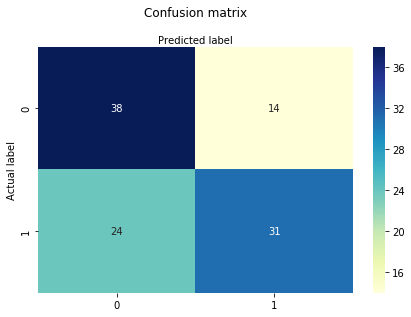

In [49]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6448598130841121
Precision: 0.6888888888888889
Recall: 0.5636363636363636
Log loss=  0.616430397039349


In [51]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()


test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010,Win,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,2010,14.61,10.39,0.656,70,66,0.475,0.387,0.734,19,73.850000,10,10,23,19,13,6,94.786730,17,Atlantic 10,Big East,77,55.0,54,74,59.0,84.0,72.0,49.0,80,16,19.0,16,17,16.0,31.0,19.0,13.0,42,0,0,0,0.272792
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,0,0,2011,Lose,10.44,4.94,0.750,75,69,0.469,0.435,0.719,19,77.743750,10,11,21,22,12,7,96.470777,19,2011,9.20,7.29,0.611,59,56,0.437,0.386,0.705,16,69.133333,10,10,20,20,13,5,85.342334,16,American Athletic,American Athletic,36,29.0,28,35,22.0,34.0,20.0,20.0,42,70,51.0,60,53,59.0,66.0,60.0,52.0,47,0,1,1,0.523766
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,0,0,2016,Lose,12.88,4.62,0.714,73,65,0.454,0.406,0.668,24,77.840000,11,10,25,23,11,6,93.782117,22,2016,20.80,8.38,0.846,78,65,0.481,0.403,0.712,15,77.917949,10,10,26,22,11,6,100.105305,20,Atlantic 10,Pacific 12,48,40.0,48,53,43.0,37.0,52.0,31.0,31,13,14.0,8,11,7.0,16.0,12.0,9.0,24,-1,1,0,0.170063
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,0,2012,Lose,-3.21,-5.80,0.588,78,76,0.479,0.468,0.691,19,80.676471,11,11,19,21,14,6,96.682464,25,2012,-1.73,-2.28,0.583,65,64,0.421,0.428,0.699,20,72.988889,10,10,19,24,11,7,89.054651,19,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,0,0.389349
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,1,2016,Win,16.75,2.19,0.853,72,57,0.496,0.412,0.745,14,69.458824,9,7,25,19,10,4,103.658537,14,2016,11.57,3.77,0.743,74,66,0.461,0.422,0.705,22,79.537143,11,9,25,24,12,7,93.038293,21,West Coast,Atlantic 10,25,25.0,11,20,18.0,14.0,23.0,17.0,26,50,43.0,46,54,30.0,52.0,44.0,22.0,50,0,0,1,0.551166


In [52]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['predicted_result','game_result','pred_win_prob','team_t','seed_t','conf_name_t', 'team_o','seed_o', 
                    'conf_name_o','top_conf','season_t','round']]

print("Total missed predictions= ", missed_predictions.shape[0])

missed_predictions


Total missed predictions=  38


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,predicted_result,pred_win_prob
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,0,2014,Lose,23.13,7.55,0.917,76,60,0.470,0.406,0.731,16,73.861111,10,10,24,21,10,7,102.895826,22,2014,14.11,9.72,0.611,70,65,0.436,0.403,0.686,19,75.550000,12,11,25,23,10,3,92.653872,20,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,1,0.802213
514,2013,16,2013-03-28,2,Miami (FL),7aec5187-cb1b-45e5-8f7d-406d766cdc73,3,Marquette,06f7c904-0ac7-4125-b0f4-f4871bb69057,0,0,2012,Lose,16.99,7.88,0.806,69,60,0.455,0.400,0.684,15,72.694444,9,10,22,22,10,6,94.917845,18,2012,14.04,8.58,0.743,68,62,0.457,0.404,0.730,17,74.771429,11,11,19,19,13,6,90.943829,21,Atlantic Coast,Big East,14,9.0,9,11,6.0,14.0,12.0,4.0,14,22,21.0,17,17,18.0,25.0,17.0,13.0,25,1,0,1,0.704256
394,2013,32,2013-03-24,12,Ole Miss,d7d668ec-edaa-4d6b-be25-2ebba4128643,13,La Salle,ad9a3e21-4585-4e35-8946-290fe4a16f18,0,0,2012,Lose,14.42,4.14,0.750,77,66,0.438,0.408,0.678,18,82.538889,12,12,21,25,10,8,93.289359,24,2012,10.14,4.46,0.706,72,66,0.451,0.456,0.737,16,75.382353,9,11,18,23,11,7,95.513071,17,Southeastern,Atlantic 10,28,33.0,42,40,37.0,34.0,34.0,48.0,29,57,53.0,44,54,48.0,57.0,55.0,46.0,46,1,0,1,0.678613
366,2012,64,2012-03-15,6,UNLV,68a3227f-677f-43b0-9a3a-cad79d0df9e2,11,Colorado,9fccbf28-2858-4263-821c-fdefb3c7efa3,0,0,2011,Lose,13.55,4.37,0.743,76,65,0.457,0.410,0.676,19,80.617143,11,10,23,23,13,8,94.272753,20,2011,7.91,5.73,0.667,67,63,0.446,0.404,0.691,17,74.055556,9,10,23,22,13,5,90.472618,22,Mountain West,Pacific 12,24,34.0,27,27,27.0,33.0,26.0,18.0,37,80,81.0,76,63,64.0,75.0,63.0,62.0,68,-1,0,1,0.677992
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,0,0,2015,Lose,21.61,9.78,0.743,78,66,0.449,0.424,0.673,27,85.394286,15,8,23,22,14,9,91.341006,27,2015,9.23,-5.47,0.824,80,63,0.478,0.438,0.735,20,80.100000,11,9,23,22,12,9,99.875156,20,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,1,0.656541
430,2012,68,2012-03-14,16,Lamar,eda6c307-1e0f-4a28-82f4-ee9653b343fb,16,Vermont,18e89867-9201-41ce-ba19-fadddf92fa17,0,0,2011,Lose,2.41,-3.77,0.657,73,65,0.432,0.421,0.720,18,81.342857,14,11,22,23,11,8,89.743590,24,2011,0.98,-5.19,0.667,67,60,0.443,0.406,0.739,17,73.461111,11,10,21,21,12,6,91.204719,19,Southland,America East,115,102.0,121,137,129.0,103.0,130.0,108.0,135,147,137.0,145,162,149.0,118.0,147.0,135.0,136,0,0,1,0.627590
440,2012,64,2012-03-16,7,Notre Dame,80962f09-8821-48b6-8cf0-0cf0eea56aa8,10,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,0,0,2011,Lose,11.18,6.47,0.647,66,61,0.434,0.414,0.704,14,70.917647,10,11,20,23,10,5,93.065693,19,2011,9.59,6.22,0.639,70,67,0.453,0.402,0.695,20,76.711111,10,11,22,23,12,6,91.251448,22,Atlantic Coast,Big East,42,39.0,36,36,37.0,41.0,36.0,39.0,29,55,53.0,57,55,50.0,58.0,52.0,41.0,60,1,0,1,0.611170
208,2010,16,2010-03-25,1,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,5,Butler,bdb7d7a4-45f8-4bf3-ab85-15488c451494,0,0,2009,Lose,21.72,7.21,0.857,80,66,0.516,0.398,0.677,15,81.457143,11,13,26,20,15,9,98.211154,21,2009,14.37,5.08,0.868,68,59,0.442,0.416,0.738,17,71.72

In [53]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(200, max_features='sqrt',
                                                                   min_samples_split=10, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

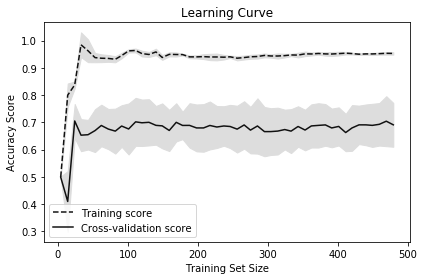

In [54]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [42]:
scores = cross_val_score(RandomForestClassifier(200, max_features='sqrt',
                                                                   min_samples_split=10, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0), X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.6930992313067785
